# Sephora Sentiment Prediction Classifer

## Introduction
#### The Sentiment Prediction includes 2 main objectives
1. sentiment prediction
- to explore and train a classfier to predict the sentiment of reviews using NB
- to understand key features contributing to the sentiments 

2. Aspect-Based Sentiment Analysis (ABSA)
- to deal with mixed sentiments
- potentially to mine sentiment keywords using EDA

#### the content of this notebook includes the followings
- Baseline model
- Advanced EDA to understand potential hyper tuning
- Naive Bay model Fine Tuning 
- explore Aspect-Based Sentiment Analysis (ABSA)

## About classfier pipeline


the defination are stored seperately in sentiment_nb.py file, and import into the jupyter notebook for cleaer flow, some functions are listed below:

class classifer
- preprocesser: lowercase, stopword, lemmatizer, remove_plural, customized_stopword
- vectorizer: count, tfidf, word2vec
- naive bayes classfier: preprocessors -> vectorizer -> train -> evaluate

class Visualization
- draw confusion_matrix for different labels
- draw samples of wrongly classfied text to understand why its wrongly labeled
- show top features which contributes to the prediction 

class Validator
- take in munual text input
- predict the label for munual validation

## Data Import 

In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
from sentiment_classifier.naive_bayes_utils import NaiveBayesClassifier, Validator, NaiveBayesVisualization

In [2]:
# set display options for max column width
pd.set_option('display.max_colwidth', 30)

latest_review = pd.read_csv('data/latest_review.csv')
latest_review.head(3)

/var/folders/8z/fr1y76rn6js5w526_mc9y1hh0000gn/T/ipykernel_43816/3002317940.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  latest_review = pd.read_csv('data/latest_review.csv')


,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,...,hair_color,product_id,product_name,brand_name,price_usd,primary_category,secondary_category,tertiary_category,true_sentiment,length
0,1796832802,3,0.0,0.714286,7,2,5,2022-12-31,I decided to try this as I...,"Decent, but cheaper produc...",...,red,P420652,Lip Sleeping Mask Intense ...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,neutral,172
1,10255886039,2,0.0,0.500000,2,1,1,2022-12-31,Might as well be putting o...,Where’s the smell??,...,NaN,P420652,Lip Sleeping Mask Intense ...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,negative,160
2,5049431408,5,1.0,1.000000,4,0,4,2022-12-31,Love this lip mask nothing...,Must buy!,...,blonde,P420652,Lip Sleeping Mask Intense ...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,positive,92


In [3]:
# understand what are the columns in the dataset
latest_review.columns

Index(['author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd',
       'primary_category', 'secondary_category', 'tertiary_category',
       'true_sentiment', 'length'],
      dtype='object')

In [4]:
# only keep relevent cols to reduce processing time
columns_to_keep = ['rating', 'is_recommended', 'helpfulness','submission_time', 
                   'review_text','review_title', 'length',
                   'product_name', 'brand_name', 'price_usd',
                   'primary_category', 'secondary_category', 'tertiary_category',
                   'true_sentiment', ]
latest_review = latest_review[columns_to_keep]

In [5]:
# set color scheme to "set2“
sns.color_palette("pastel")

# Get the color palette as a list
color_palette = sns.color_palette()

## Model Training Baseline

After simple EDA (refer to main file), a classfier pipeline using Naive Bay model is constructed. The baseline model is using clean text without further engineered features. 

The parameters used for the baseline model as below:
- target variables: true sentiments (<=2: negative, =3: neutral, >=4: positive)
- input data: all reviews
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count


In [6]:
# train baseline model with latest_review for the baseline model
preprocessors = ['lowercase']
baseline_nb_classifier = NaiveBayesClassifier(data=latest_review, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = baseline_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [7]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.88093
Test Accuracy: 0.87062


In [8]:
# set column labels
labels = sorted(baseline_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
baseline_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.88093
precision: 0.88494
recall: 0.88093
f1: 0.88279
f2: 0.88173

Confusion Matrix:


,Predicted negative,Predicted neutral,Predicted positive
True negative,7539,1136,1812
True neutral,1489,4203,3106
True positive,2234,3956,89861


In [9]:
# get train evaluation for test set
print("\nTest:")
baseline_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.87062
precision: 0.87106
recall: 0.87062
f1: 0.87080
f2: 0.87071

Confusion Matrix:


,Predicted negative,Predicted neutral,Predicted positive
True negative,4496,907,1408
True neutral,1196,2181,2413
True positive,1442,2582,60266


In [10]:
results_list = []

new_entry = {
    'Name': 'Baseline Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, negative, neutral',
    'remarks': 'baseline model'
}

results_list.append(new_entry)
# results_list


In [11]:
# sample incorrect prediction 
from sentiment_classifier.naive_bayes_utils import NaiveBayesVisualization
visualizer = NaiveBayesVisualization(baseline_nb_classifier)
visualizer.display_incorrect_samples(2)

Review: Love this lip mask nothing else will do Aquaphor and Vaseline just aren’t as moisturizing as this mask is I recommend it to everyone I know￼
Review Procrssed: love this lip mask nothing else will do aquaphor and vaseline just aren’t as moisturizing as this mask is i recommend it to everyone i know￼
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I had chapped lips suddenly (normally not a problem for me) and after several days of lip balm/chapstick, they only started healing once I started using this. I had a sample from a reward or birthday gift. I will definitely keep it on hand for the future.
Review Procrssed: i had chapped lips suddenly normally not a problem for me and after several days of lip balmchapstick they only started healing once i started using this i had a sample from a reward or birthday gift i will definitely keep it on hand for the future
Actual Sentiment: positive
Predicted Sentiment: negative

Review: This product has been blowing up so I

it is observed from both confusion matrix and sample data:
- the classfier does not prefrom well with neutral labeled data. With human observation, many of 'netural' data are not netural but contains sentiments, such data might create a nosie to the whole dataset. 
- misclassification among positive and negtive to be imporved  

## model evaluation

1. Accuracy: In imbalanced datasets, accuracy can be misleading as a model predicting the majority class will have a high accuracy.
- Accuracy = (TP + TN) / (TP + TN + FP + FN)

2. Precision: High precision means that of the reviews flagged as negative, most were actually negative
- Precision = TP / (TP + FP)

3. Recall: High recall means the model detected most of the negative reviews.
- Recall = TP / (TP + FN)

4. F1-Score: Balances the trade-off between precision and recall.
- F1-Score = 2 x (Precision x Recall) / (Precision + Recall)

5. F2-Score: Useful when recall (or avoiding false negatives) is more important than precision.
- F2-Score = (1 + 2^2) x (Precision x Recall) / (2^2 x Precision + Recall)

6. Confusion Matrix: Shows where the model is making mistakes.
- TP = True Positives
- FP = False Positives
- TN = True Negatives
- FN = False Negatives


Primary metrics: F2 & RECALL (Weighted Average)

we are dealing with class imbalance, the weighted average might be more informative.

### Macro Average and Weighted Average in Metrics

1. Macro Average: calculates the metric independently for each class and then takes the average, treating all classes equally, regardless of their size.

- **Formula** (for precision as an example):
  - Macro-Precision = (1/N) x SUM(Precision_i) from i=1 to N

2. Weighted Average: It calculates metrics for each label, and finds their average weighted by the number of true instances for each label. This method takes class imbalance into account. Especially useful when the dataset has class imbalance.

- **Formula** (for precision as an example):
   - Weighted-Precision = SUM(w_i x Precision_i) from i=1 to N


using the weighted average would be more representative of the model's performance on the dataset.

ref: https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

## Advanced EDA

In [12]:
latest_review.columns

Index(['rating', 'is_recommended', 'helpfulness', 'submission_time',
       'review_text', 'review_title', 'length', 'product_name', 'brand_name',
       'price_usd', 'primary_category', 'secondary_category',
       'tertiary_category', 'true_sentiment', 'reviews_processed',
       'prediction'],
      dtype='object')

### deal with duplicated reviews

In [13]:
# Adjust pandas display options
pd.set_option('display.max_colwidth', None)

In [14]:
# check % of duplicated rows
total_rows = len(latest_review)
unique_reviews = latest_review['review_text'].nunique()
duplicates = total_rows - unique_reviews
percentage_duplicates = (duplicates / total_rows) * 100

print(f"Total number of rows: {total_rows}")
print(f"Number of unique reviews: {unique_reviews}")
print(f"Number of duplicate reviews: {duplicates}")
print(f"Percentage of duplicate reviews: {percentage_duplicates:.2f}%")


Total number of rows: 192227
Number of unique reviews: 172007
Number of duplicate reviews: 20220
Percentage of duplicate reviews: 10.52%


In [15]:
# sample top 10 helpfulness duplicated reviews
duplicate_reviews = latest_review[latest_review.duplicated(subset='review_text', keep=False)].sort_values('review_text')
selected_columns = ['rating', 'submission_time', 'review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']
duplicate_reviews.sort_values(by=['helpfulness', 'review_text'], ascending=False)[selected_columns].head(5)


,rating,submission_time,review_text,review_title,product_name,brand_name,price_usd
4665,5,2022-12-27,♡AMAZING!♡I love this product so muchh because it really helps my skin that is full of pimples.This is week 2 of using this product.,LOVE IT! I WILL TOTALLY BUY AGAIN,Mini Superfood Antioxidant Cleanser,Youth To The People,14.00
3814,5,2022-12-27,♡AMAZING!♡I love this product so muchh because it really helps my skin that is full of pimples.This is week 2 of using this product.,LOVE IT! I WILL TOTALLY BUY AGAIN,Superfood Antioxidant Cleanser,Youth To The People,39.00
19860,5,2022-07-19,•consistency reminds me kind of like a makeup primer? (which I like)•rubs in completely clear & doesn’t leave any shine•there’s a scent but not overpowering •i’d recommend a moisturizer before this sunscreen,I dig it,Unseen Sunscreen SPF 40 PA+++,Supergoop!,48.00
20395,5,2022-07-19,•consistency reminds me kind of like a makeup primer? (which I like)•rubs in completely clear & doesn’t leave any shine•there’s a scent but not overpowering •i’d recommend a moisturizer before this sunscreen,I dig it,Mini Unseen Sunscreen SPF 40 PA+++,Supergoop!,22.00
159647,5,2022-07-30,İ love it and makes my dull skin refreshed and bright.,NaN,Fulvic Acid Brightening Cleanser,The INKEY List,11.99


after checking the duplicated reviews, the duplicated reviews are made by the same customer, on the same day, for the same product but in different size. It can be considered as noise in the trainning data as it populates 10% of data, such data should be removed to keep only one row with the normal size. 

In [16]:
# drop duplicates and store into new df
df = latest_review.drop_duplicates(subset='review_text', keep='first')

### understand the text through word cloud

#### no stopwords

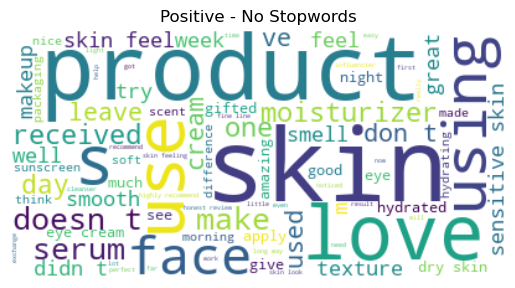

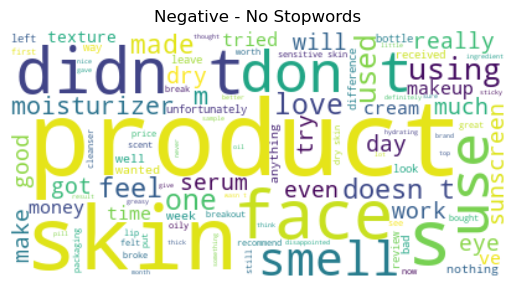

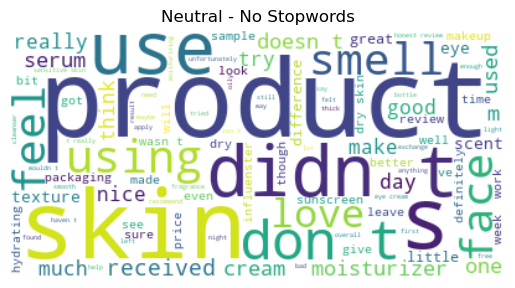

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sentiments = ['positive', 'negative', 'neutral']

for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()

    # Use the STOPWORDS set from WordCloud to exclude common stopwords
    wc1 = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=100).generate(text)

    plt.imshow(wc1, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} - No Stopwords")
    plt.show()


It has been observed that this review dataset contains a high frequency of product-related terms, such as 'skin', 'product', and 'face', across all sentiment categories. These words don't significantly influence predictions and should be classified as stopwords. 

Many reviews directly address the product; therefore, such information should be filtered out. While certain products might display predominantly positive or negative sentiments, including this data could introduce predefined biases or stereotypes about the product. Consequently, this could compromise the effectiveness of our sentiment classifier.

#### Only with Custom Stopwords

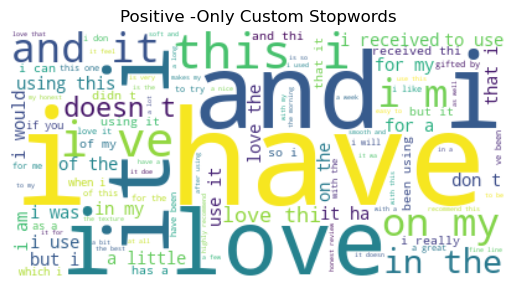

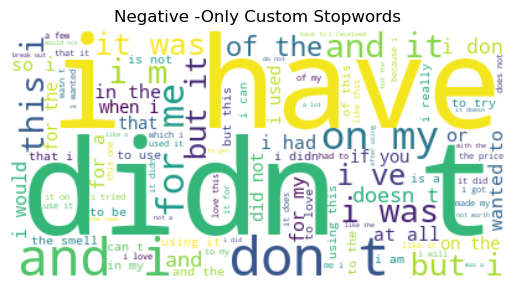

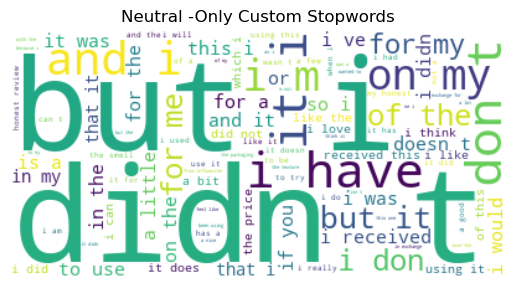

In [18]:
# draw wordcloud with custom stopword
custom_stopwords = {'skin','product','face','cream','serum','moisturizer','makeup','eye','sunscreen','eyes','products','s'}
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()
    wc2 = WordCloud(background_color="white", max_words=100, stopwords=custom_stopwords).generate(text)
    plt.imshow(wc2, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} -Only Custom Stopwords")
    plt.show()

After removing the custom stopwords from the Sephora dataset, the word cloud is dominated by typical stopwords. These don't offer insights into the three distinct sentiment categories. Therefore, additional common English stopwords should be included.

#### custom & common english stopword

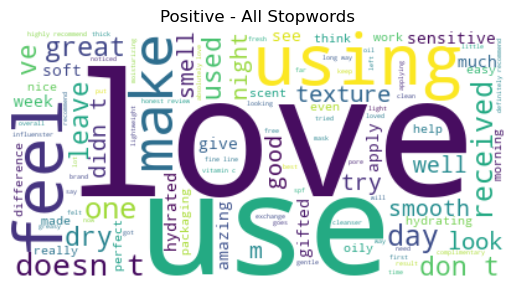

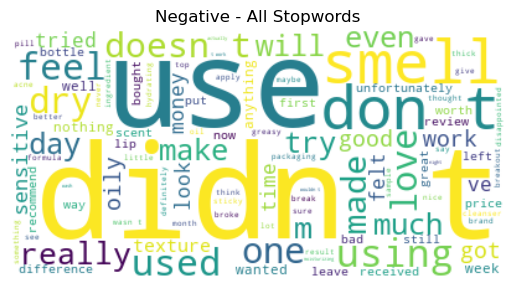

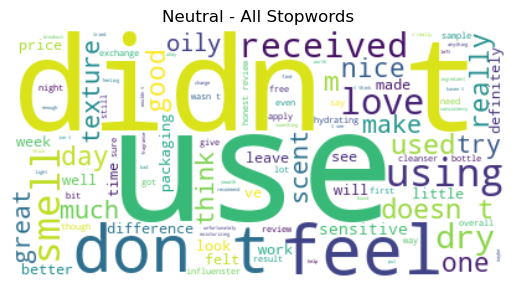

In [19]:
all_stopwords = STOPWORDS.union(custom_stopwords)
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()
    wc3 = WordCloud(background_color="white", max_words=100, stopwords=all_stopwords).generate(text)
    plt.imshow(wc3, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} - All Stopwords")
    plt.show()

With the integration of these combined stopwords, the word cloud for the three sentiments displayed a noticeable distinction. These stopwords will be referenced later in the notebook and within the Python definition

### understanding target variables/lebal: rating & is_recommended

can is_recommended be used as target variables? 

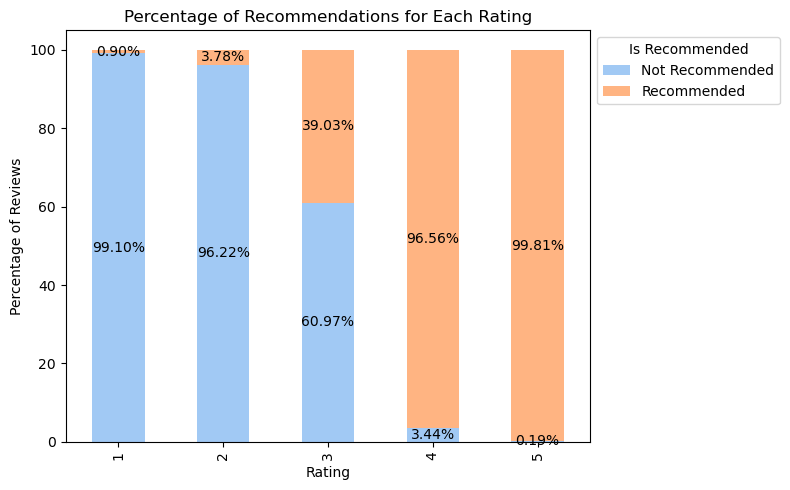

In [20]:
# understand % of is_recommended for different ratings
pivot_data = df.groupby(['rating', 'is_recommended']).size().unstack().fillna(0)
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Plotting
ax = pivot_data_percentage.plot(kind='bar', stacked=True, figsize=(8, 5), color=sns.color_palette("pastel", len(pivot_data_percentage.columns)))
ax.set_title('Percentage of Recommendations for Each Rating')
ax.set_xlabel('Rating')
ax.set_ylabel('Percentage of Reviews')
ax.legend(title="Is Recommended", labels=["Not Recommended", "Recommended"], loc="upper left", bbox_to_anchor=(1, 1))

# Annotate with the percentage values
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x+width/2, y+height/2, f"{height:.2f}%", ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

logically, user give higher ratings would more likely to recommend certain products 
- why some users recommend a product even if they give it a rating of 1? 
- why some don't recommend a product even if they give it a rating of 5?
- is is_recommended a valuable column to use? 

To achieve objectives above:
- Sample top 10 helpful(helpfulness) review where a user gave a rating of 1 but recommended the product.
- Sample top 10 helpful(helpfulness) review where a user gave a rating of 5 but didn't recommend the product.
- Generate word cloud for each type

In [21]:
# sample reviews with rating 1 but recommended
recommended_with_1 = df[(df['rating'] == 1) & (df['is_recommended'] == 1)]

# Display the top 10 reviews based on helpfulness
top_5_reviews = recommended_with_1.nlargest(5, 'helpfulness')
display(top_5_reviews[['review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']])

,review_text,review_title,product_name,brand_name,price_usd
38428,"Love the original, hate the refill. Purchased the refill to save some money and plastic. I followed the instructions to replace the refill and The pump no longer works and I can’t unscrew the refill to get the product out by hand. I’ve essentially wasted the $42 and my local Sephora doesn’t carry this product so I can’t exchange it. I’m just going to see if I can break the container open to salvage some of my purchase. Don’t buy the refill.",NaN,Barrier+ Triple Lipid-Peptide Face Cream,Skinfix,54.0
42566,"It feels very cooling when first applied, but that’s it. It doesnt work, it doesn’t depuff, it doesn’t anything. I’ve been using it for months and I haven’t seen any change at all. It does absorb easily and the gel like texture makes it easy to apply in specific areas, but it doesn’t do anything.",Doesn't work,Caffeine 5% + EGCG Depuffing Eye Serum,The Ordinary,8.9
54137,I didn’t use this product because it did not have a safety seal when you opened it. It was just there. I prefer not to put product around my eyes.,I didn't use it,Advanced Night Repair Eye Gel-Cream,Estée Lauder,72.0
58368,"I do not like the knew packaging. A lot more formula comes out, I feel like I use more product now then before before and the bottle keeps opening all together I constantly have to be Putting it back together",I miss the old formula,C-Firma Fresh Vitamin-C Day Serum,Drunk Elephant,78.0
62118,The product is perfect but imagine purchasing the item and have a complete reaction due to the product being expired!! Thank you Sephora for not pulling your expired items off the shelf. Expectation date May 2022 and it’s almost 2023. I returned the product for an exchange but all of them were expired!Speechless!!,Check The Expiration Date,CC+ Cream Oil-Free Matte with SPF 40,IT Cosmetics,44.0


In [22]:
# sample reviews with rating 5 but not recommended
not_recommended_with_5 = df[(df['rating'] == 5) & (df['is_recommended'] == 0)]

# Display the top 10 reviews based on helpfulness
top_5_reviews_not_recommended = not_recommended_with_5.nlargest(5, 'helpfulness')
display(top_5_reviews_not_recommended[['review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']])


,review_text,review_title,product_name,brand_name,price_usd
1535,"Love this cleanser, use it every day. Very gentle on dry skin. Doesn’t take off my makeup super well so I use it as the second part of a double cleanse if I wear makeup.",NaN,Soy Hydrating Gentle Face Cleanser,fresh,39.0
1556,Soft and nice. Smells almost neutral. Does not dry out my skin.,NaN,Soy Hydrating Gentle Face Cleanser,fresh,39.0
4109,"I have very sensitive, combination skin. This cleanser is the only one I’ve been able to find that has cleared my skin after one use, and keeps my skin under control all around. It’s gentle, but really deeply cleanses without over stripping it. I keep coming back to it time and time again.",GO TO,Superfood Antioxidant Cleanser,Youth To The People,39.0
7637,Loved it deff worth the money for the full size. I don’t use it often but when my skin just need a gentle scrub this is my go to. It feels so smooth & clean after.,Loved it,Mini Daily Microfoliant Exfoliator,Dermalogica,18.0
14584,Best moisturizer for my combination skin. I’ve been using for a little over a year now and my skin has changed drastically,NaN,The Water Cream Oil-Free Pore Minimizing Moisturizer,Tatcha,70.0


create word cloud to understand high frequency terms

In [23]:
# Define a function to draw the word clouds
def get_word_cloud_text(df):
    return " ".join(review for review in df['review_text'])

def draw_word_cloud(text, ax, title):
    wordcloud = WordCloud(background_color="white", max_words=100, stopwords=all_stopwords).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)

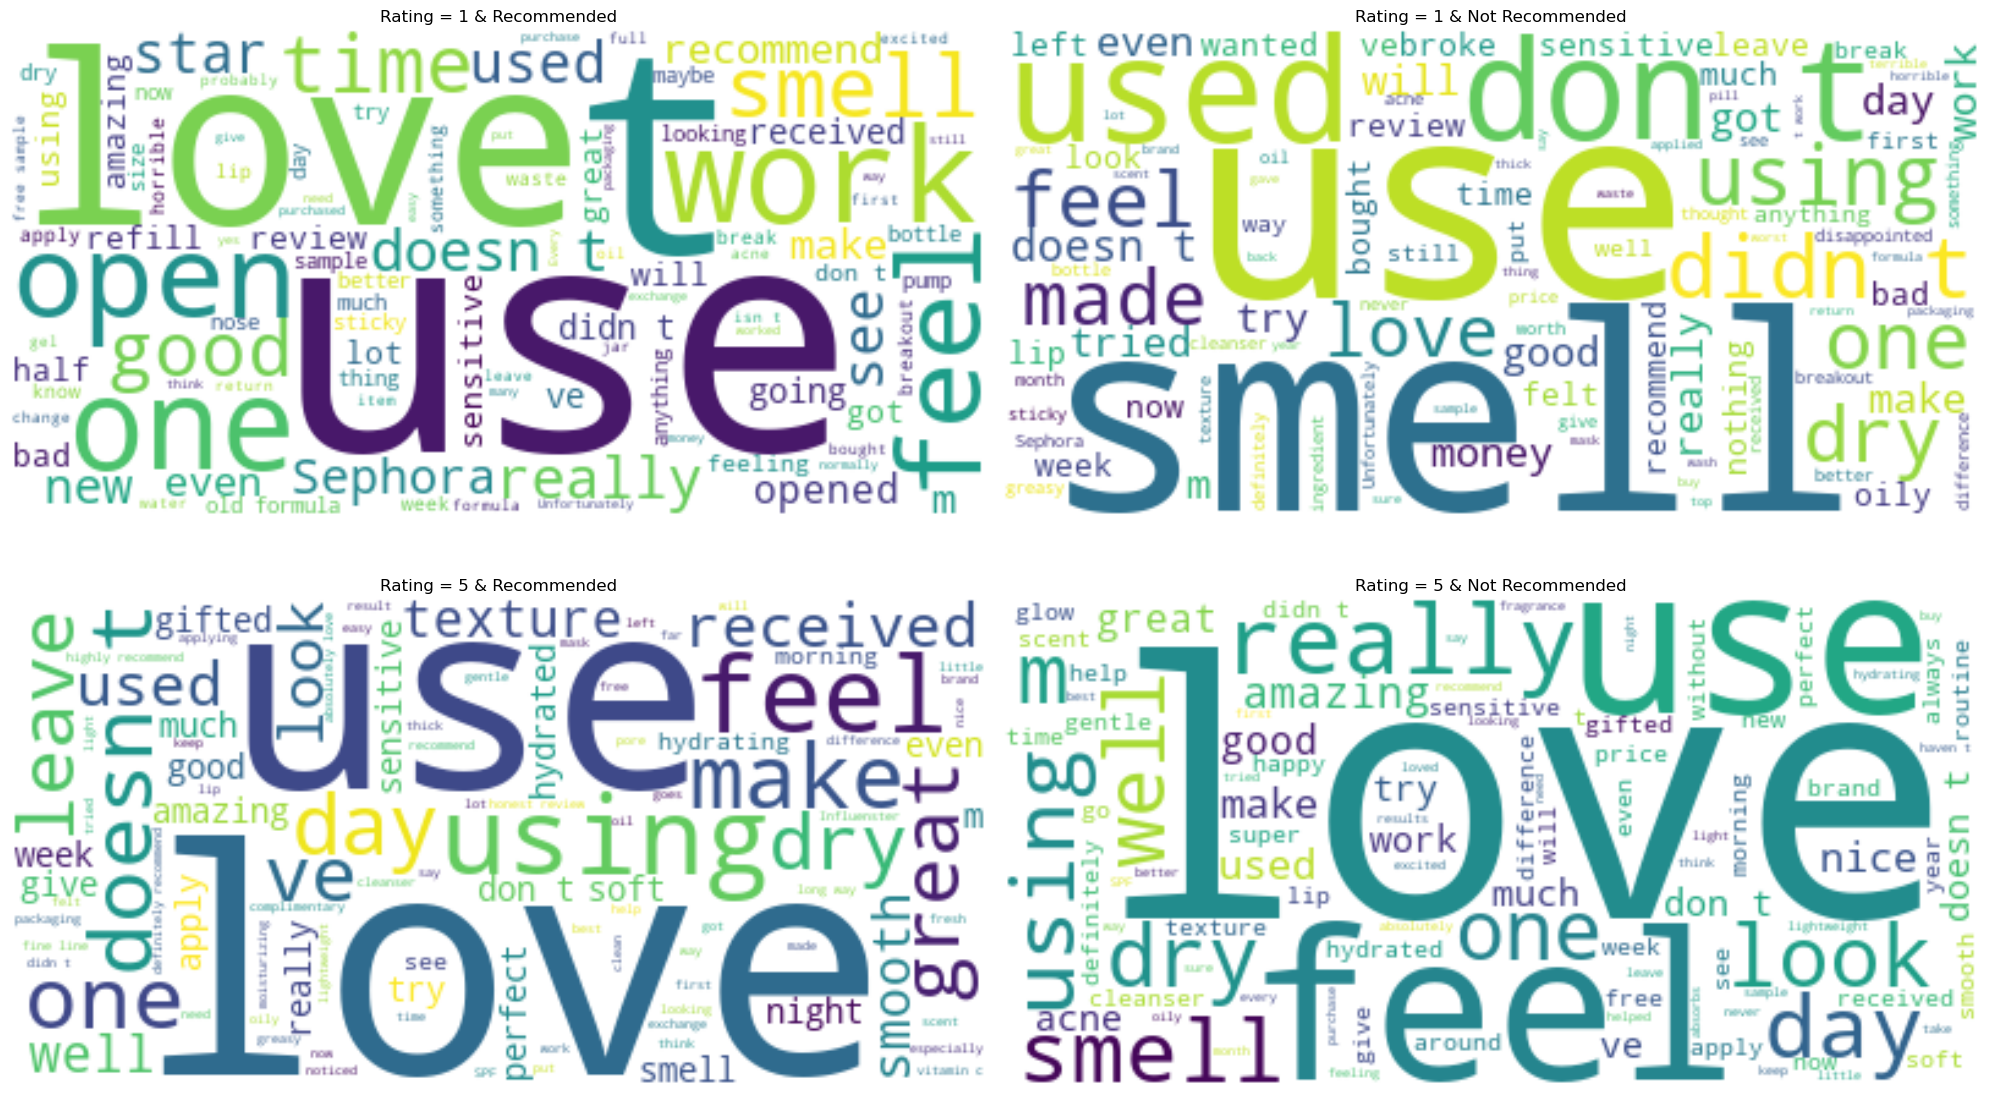

In [24]:
# get dataframe
recommended_with_5 = df[(df['rating'] == 5) & (df['is_recommended'] == 1)]
not_recommended_with_1 = df[(df['rating'] == 1) & (df['is_recommended'] == 0)]

# draw word cloud
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

draw_word_cloud(get_word_cloud_text(recommended_with_1), axs[0, 0], "Rating = 1 & Recommended")
draw_word_cloud(get_word_cloud_text(not_recommended_with_1), axs[0, 1], "Rating = 1 & Not Recommended")
draw_word_cloud(get_word_cloud_text(recommended_with_5), axs[1, 0], "Rating = 5 & Recommended")
draw_word_cloud(get_word_cloud_text(not_recommended_with_5), axs[1, 1], "Rating = 5 & Not Recommended")

plt.tight_layout()
plt.show()

looking at the sample reviews and word cloud above: 
- rating = 1 but recommended: usually has no issue with the product itself, but either services, condition of the product etc. this group of reviews should be flagged out and feedback to the relevent stakeholders. 
- rating = 5 but not recommended: generally does not show bad emotions/sentiments about the products and related services, potentially a default value = 0 when people doesnt leave an input, or put wrongly. 
- is_recommended is not a good feature to used as target variables

### understanding target variables/lebal: rating = 3

zoom onto reviews with ratings 3
- it observed that half of 3 review recommend, and the half does not
- current classfier failed to predict netural labels well
- understand the true sentiment
- is such data noise to the dataset?

To achieve above:
- some sample data
- wordcloud

In [25]:
# Filtering out reviews with ratings of 3
reviews_with_3 = df[df['rating'] == 3]

# Fetching top 10 samples for both categories
recommended_samples = reviews_with_3[reviews_with_3['is_recommended'] == 1].sample(10)
not_recommended_samples = reviews_with_3[reviews_with_3['is_recommended'] == 0].sample(10)


In [26]:
# Display the samples
pd.set_option('display.max_colwidth', None)

print("Top 10 Sample Reviews with Rating of 3 that are Recommended:")
display(recommended_samples[['review_text', 'is_recommended', 'true_sentiment']])

print("\nTop 10 Sample Reviews with Rating of 3 that are Not Recommended:")
display(not_recommended_samples[['review_text', 'is_recommended', 'true_sentiment']])

Top 10 Sample Reviews with Rating of 3 that are Recommended:


,review_text,is_recommended,true_sentiment
168712,"If it wasn’t for the stomach pain and extreme bowel issues this pill causes me, I would have gave it 5 stars. This definitely works, but the side effects are not worth it.",1.0,neutral
73557,"I am 43 with genetic dark circles so any eye cream that says it with brighten and de-puff is going to be in my wheelhouse. This cream, gifted by Algenist, is very thick and rich in texture, but what I found interesting is how quickly it absorbed and dried down. I have dry skin so I usually use very rich and emollient skincare that leaves some sort of residue but this cream seemed to just vanish. It worked well under makeup and didn’t cause any irritation. I can’t say that I have seen a drastic reduction in my dark circles but I am hopeful that with more time I might. I would say that if you want a nice eye cream this is great but if you are looking for dramatic results I can’t say this cream will provide them.",1.0,neutral
153891,It’s nice for treating yourself spa night! My skin was very hydrated but that was it. It’s nice for the price and I’d definitely do again,1.0,neutral
97696,"I love the glow it serves when I use it in the morning. I love that it’s vegan. However, I haven’t seen much improvement to my dark under circles. Note: I’ve been using this product for only three weeks. I will update after I finish the jar.",1.0,neutral
76743,I got this from influenster for testing purposes. It’s too soon to I know if I love it or just like it.,1.0,neutral
43539,This cream smells like a wet dog but works really well. If you can get past the smell you’ll love it.,1.0,neutral
38683,"Was looking for an alternative to a Korean foaming rice wash cleanser, but I didn’t expect that this cleanser was bit more of an exfoliating type. It is important to note (specially to people with extra sensitive skin) that it has microbeads in it that dissolves after a while. All in all, does the job ok as a cleanser, but might not repurchase cause of the microbeads) and will look specifically for gentle foaming cleansers instead.",1.0,neutral
27568,"This is an amazing toner !! Not only did I use it on my face to help with pimples and redness but I also used it as a deodorant for my underarms and it got rid of ingrown hairs, darkness and pimples !! It’s made a huge change for my body and I’m very satisfied with my purchase. Will definitely buy again",1.0,neutral
171380,"would give 3.5, noticed a positive difference in my sensitive and dry skin, did not notice a huge difference in my natural *glaur* however... trying 2% Retinol next or something new/else! I would recommend Paula’s Choice, but be honest about this product’s efficacy",1.0,neutral
158267,Definitely a light moisturizer if you have super dry skin I’d opt for something stronger. Has a very slight citrus smell that I love. Doesn’t off much glow but does make the skin feel nice and supple :),1.0,neutral



Top 10 Sample Reviews with Rating of 3 that are Not Recommended:


,review_text,is_recommended,true_sentiment
166859,"Don’t like it, I don’t moisturize my skin good and really it hasent really work plus the container it runny and it spills everywhere",0.0,neutral
75678,I was so excited to receive this product but at the end was not too happy wasn’t as great as it says didn’t see much of a difference the way the product claims to have,0.0,neutral
96108,The most frustrating thing about this product is the packaging. For the price they really could do better. This stuff skeets out so fast and so far you end up loosing half of it. And you have to pump it 15 times for you get any.,0.0,neutral
113655,"I bought this to try something different than the classic laneige lip mask. It’s *fine*. The smell is very pretty and rosy which I like, but moisture wise, the laneige wins by a mile. I use the rose stick balm and I feel like it actually does a better job than this. It’s not bad enough that I think I’ll return it, but I definitely wouldn’t repurchase it.",0.0,neutral
124267,"The lather isn’t bad. The texture is creamy on the skin. A smidge drying.. but wow that smell could gag a maggot. It’s not a horrible smell, but not what you’d expect from a brand like Dior. It is so dang strong of a smell that I was sick to my stomach. It’s not even a pretty Dior perfume smell. Smells have never bothered me but wow this was kickin. If you’re sensitive to smells, skip this. I use the Chanel version of this and it’s much better!",0.0,neutral
186668,My skin felt soft and plump temporarily but I did not notice any visible different after 1 use.,0.0,neutral
68499,"I have ever lip mask/chapstick ever made and the laneige is my favorite. I bought this just because I love Tatcha, but I will not be buying this product again. It’s good but there is better for less. This lip mask is over priced",0.0,neutral
29633,"I got this product complimentary from Influenster and Estee Lauder in exchange for my honest review. I have combination skin, very oily t-zone, and this product made my skin even oiler. I woke up a giant greaseball every time I used this product. It also has a scent, not too overpowering, but rather old lady-ish and mature. I did use this product on my hands (because they are super dry from all the hand washing and sanitizing) and it did leave my hands soft and silky smooth. If it wasnt for the price point, I might consider buying this to use as a hand cream at night. The cream is thick and silky, so this product might work really well for those that have dry skin (like it did on my hands), more so than combo or oily skin types. I also didn’t see any improvements in lifting or firmness, but since I did receive a sample size, I’m not sure I was able to test the product long enough to see if there are any long term benefits and results.",0.0,neutral
43037,I received this product as a free sample from biossance and Influenster in exchange for my unbiased review. I tried this moisturizer and while it’s nice that it’s unscented from a fragrance standpoint the smell is off-putting to me. The cream texture of the moisturizer felt nice going on but I didn’t notice any lasting improvement to the moisture in my skin. Lastly it separated foundations and makeup that I never have issues with under thicker moisturizers,0.0,neutral
74088,My husband is using ALGENIST TRIPLE ALGAE EYE RENEWAL BALM for 3 days now.He has puffy eyes and dark circles too.Is a very short time to evaluate a product but i see that the dark circles are the same but the dkin looks firmer.This product may do a difference after a long time of use but i don’t think i’ll purchase it because is expensive,0.0,neutral


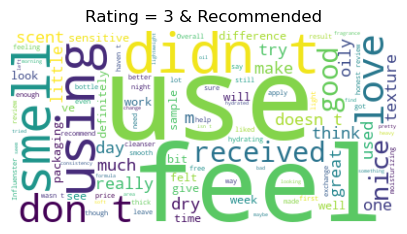

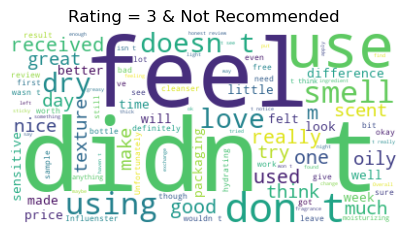

In [27]:
def generate_word_cloud(df, title):
    text = " ".join(review for review in df['review_text'])
    wordcloud = WordCloud(background_color="white", max_words=100,stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(5, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds
generate_word_cloud(reviews_with_3[reviews_with_3['is_recommended'] == 1], "Rating = 3 & Recommended")
generate_word_cloud(reviews_with_3[reviews_with_3['is_recommended'] == 0], "Rating = 3 & Not Recommended")


review with rating of 3, seems to have both negtive and positive feedbacks. Thus such reviews could be recognozied as noise to be excluded
- true neutral 
- mixture of feelings, postive towards certain asepect, negative towards certain aspect 
- showing postive or negtive sentiments 

In [28]:
# create a new dataframe df_no_3 to store only positive and negative feedbacks
df_no_3 = df[df['rating'] != 3]
pd.set_option('display.max_colwidth', 50)
df_no_3.head(3)


,rating,is_recommended,helpfulness,submission_time,review_text,review_title,length,product_name,brand_name,price_usd,primary_category,secondary_category,tertiary_category,true_sentiment,reviews_processed,prediction
1,2,0.0,0.500000,2022-12-31,Might as well be putting on Vaseline because I...,Where’s the smell??,160,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,negative,might as well be putting on vaseline because i...,negative
2,5,1.0,1.000000,2022-12-31,Love this lip mask nothing else will do Aquaph...,Must buy!,92,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,positive,love this lip mask nothing else will do aquaph...,negative
3,4,1.0,0.333333,2022-12-31,I really enjoy this product! Amazing smell and...,Lovely smell,148,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Skincare,Lip Balms & Treatments,NaN,positive,i really enjoy this product amazing smell and ...,positive


### understanding target variables/lebal: unbalanced data

In [29]:
df_no_3.columns

Index(['rating', 'is_recommended', 'helpfulness', 'submission_time',
       'review_text', 'review_title', 'length', 'product_name', 'brand_name',
       'price_usd', 'primary_category', 'secondary_category',
       'tertiary_category', 'true_sentiment', 'reviews_processed',
       'prediction'],
      dtype='object')

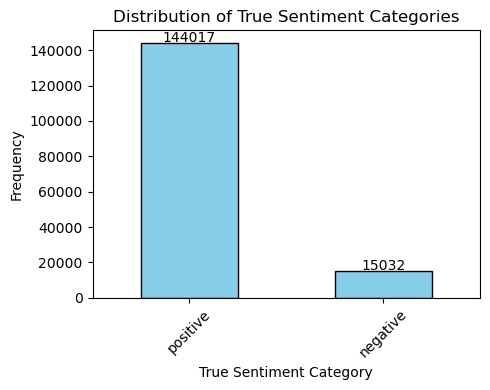

In [30]:
# check distribution of sentiments
value_counts = df_no_3['true_sentiment'].value_counts()

fig, ax = plt.subplots(figsize=(5, 4))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
ax.set_title('Distribution of True Sentiment Categories')
ax.set_xlabel('True Sentiment Category')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45) 

# Add count numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.tight_layout()  

# Display the plot
plt.show()


In [31]:
# undersampling 

# Separate majority and minority classes
df_majority = df_no_3[df_no_3['true_sentiment'] == 'positive']
df_minority = df_no_3[df_no_3['true_sentiment'] == 'negative']

# Undersample the majority class
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)
df_undersampled = pd.concat([df_majority_undersampled, df_minority], axis=0)
df_undersampled = df_undersampled.sample(frac=1, random_state=2023).reset_index(drop=True)


In [32]:
# Subtract the undersampled majority data from the entire majority dataset
df_majority_not_used = df_majority.drop(df_majority_undersampled.index)

# If you want to store it as a CSV for future use:
# df_majority_not_used.to_csv('majority_not_used.csv', index=False)


## Model Improvement 

multiple training explorations with different: 
- training data & labels
- preprocesser
- word embedding
- features

### exploration on different training data and labels

#### train with only positive and negative labels 
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: no dup data, still imbalanced
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count

In [33]:
# training data using df_no_3
preprocessors = ['lowercase']
nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [34]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94982
Test Accuracy: 0.94711


In [35]:
# set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94982
precision: 0.95205
recall: 0.94982
f1: 0.95078
f2: 0.95026

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,7101,1985
True positive,2804,83539


In [36]:
# get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94711
precision: 0.94746
recall: 0.94711
f1: 0.94728
f2: 0.94718

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,4307,1639
True positive,1726,55948


In [37]:
new_entry = {
    'Name': 'NB Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews'
}

new_entry


{'Name': 'NB Model',
 'Train Accuracy': 0.9498160936402981,
 'Train Precision': 0.9520464565486026,
 'Train Recall': 0.9498160936402981,
 'Train F1': 0.9507786304591752,
 'Train F2': 0.9502613298173023,
 'Train Confusion Matrix': [[7101, 1985], [2804, 83539]],
 'Test Accuracy': 0.9471078277271299,
 'Test Precision': 0.9474601378915405,
 'Test Recall': 0.9471078277271299,
 'Test F1': 0.9472799362399333,
 'Test F2': 0.9471782687975793,
 'Test Confusion Matrix': [[4307, 1639], [1726, 55948]],
 'Preprocesser': ['lowercase'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews'}

In [38]:
results_list.append(new_entry)
# results_list

In [39]:
# sample incorrect prediction 
visualizer = NaiveBayesVisualization(nb_classifier)
visualizer.display_incorrect_samples(2)

Review: Love this lip mask nothing else will do Aquaphor and Vaseline just aren’t as moisturizing as this mask is I recommend it to everyone I know￼
Review Procrssed: love this lip mask nothing else will do aquaphor and vaseline just aren’t as moisturizing as this mask is i recommend it to everyone i know￼
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I had chapped lips suddenly (normally not a problem for me) and after several days of lip balm/chapstick, they only started healing once I started using this. I had a sample from a reward or birthday gift. I will definitely keep it on hand for the future.
Review Procrssed: i had chapped lips suddenly normally not a problem for me and after several days of lip balmchapstick they only started healing once i started using this i had a sample from a reward or birthday gift i will definitely keep it on hand for the future
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I’ve used it for 2 months and honestl

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['prediction'] = self.validator.predict_batch(self.data['reviews_processed'].tolist())


The first and second review seems very positive, and there doesn't seem to be any overtly negative words that could have led to misclassification. The use of terms like "Aquaphor" and "Vaseline" might have been associated with negative sentiments in the training data, leading to the incorrect prediction.

The third review is negative in nature but contains positive words like "love" and "gloss." The model might have weighed these words more heavily leading to the misclassification. The last review has a mix of positive and negative sentiments, making it a bit trickier to classify. Words like "decent" could have contributed to the misclassification.

#### train with only positive and negative labels, filter out inconsistent is_recommended col 
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: no dup data, still imbalanced
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count

In [40]:
positive_and_recommended = df_no_3[(df_no_3['true_sentiment'] == 'positive') & (df_no_3['is_recommended'] == 1)]
negative_and_not_recommended = df_no_3[(df_no_3['true_sentiment'] == 'negative') & (df_no_3['is_recommended'] == 0)]

df_cleaned = pd.concat([positive_and_recommended, negative_and_not_recommended])


In [41]:
preprocessors = ['lowercase']
clean_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = clean_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [42]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95152
Test Accuracy: 0.94952


In [43]:
# set column labels
labels = sorted(clean_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
clean_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95152
precision: 0.95323
recall: 0.95152
f1: 0.95228
f2: 0.95186

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6906,1967
True positive,2610,82928


In [44]:
# get train evaluation for test set
print("\nTest:")
clean_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94952
precision: 0.95020
recall: 0.94952
f1: 0.94984
f2: 0.94966

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,4312,1505
True positive,1672,55452


In [45]:
new_entry = {
    'Name': 'clean NB Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, clean data, only positive and negative reviews'
}

# new_entry


In [46]:
results_list.append(new_entry)
# results_list

#### train with undersampling dataset
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: no dup data, undersampled to reach balanced data
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count

In [47]:
# training data using df_undersampled
preprocessors = ['lowercase']
undersample_nb_classifier = NaiveBayesClassifier(data=df_undersampled, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = undersample_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [48]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.92854
Test Accuracy: 0.91452


In [49]:
# set column labels
labels = sorted(undersample_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
undersample_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.92854
precision: 0.92879
recall: 0.92854
f1: 0.92853
f2: 0.92859

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,8457,536
True positive,753,8292


In [50]:
# get train evaluation for test set
print("\nTest:")
undersample_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.91452
precision: 0.91472
recall: 0.91452
f1: 0.91450
f2: 0.91456

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,5593,446
True positive,582,5405


In [51]:
new_entry = {
    'Name': 'Undersampled Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, balanced data with undersampling'
}

# new_entry


In [52]:
results_list.append(new_entry)
# results_list

In [53]:
# Extract the review texts and true sentiments
X_test = df_majority_not_used['review_text'].tolist()
y_test = df_majority_not_used['true_sentiment']

from sklearn.metrics import confusion_matrix

validator=Validator(undersample_nb_classifier)
predictions  = validator.predict_batch(texts=X_test)


In [54]:
# Compute the confusion matrix
matrix = confusion_matrix(y_test, predictions)

# Display the confusion matrix
print(matrix)

[[     0      0]
 [ 13494 115491]]


#### Conclusion

1. Normal Model:
- performs better on both training and testing data compared to the undersampling model
- difference between the training and testing metrics is less pronounced, suggesting that the model is generalizing better to unseen data than the undersampling model.
- But tends to misclassify negative reviews as positive, likely due to the imbalanced data.

2. Clean NB Model:
- slightly better performance than the normal model on both training and testing datasets.
- minimal difference between train and test metrics indicates its capability to generalize well to unseen data.

3. Undersampling Model:
- slightly lower metrics than the normal model but better balanced in terms of precision and recall.
- difference between train and test metrics is higher, this suggests a bit more overfitting than undersampling model
- better performance towards negative sentiments, 

Left Over Positive Reviews: about 10% positive reviews were misclassified as negative. This might be due to the nature of the undersampling method or the inherent limitations of the Naive Bayes classifier.

4. Choosing the Model: Clean NB Model

In the competitive e-commerce sphere, Sephora values customer feedback. The normal model, with its higher accuracy and larger pool size, aligns better with Sephora's aim to cater to a broader audience. The clean NB Model, being a refined version of the normal model, may offer an even better representation of customer sentiments. By identifying and emphasizing what's working well, the company aims to further delight its satisfied customers. The undersampling model, while effective at highlighting criticisms, leans too heavily on the negative, potentially missing out on a larger pool of target audience.

### exploration with different stopwords preprocessor

#### train with stopword and lowercase preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, stopword
- vectorizer: count

In [55]:
# training data using df_no_3
preprocessors = ['lowercase','stopword']
sw_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = sw_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [56]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95042
Test Accuracy: 0.94811


In [57]:
# set column labels
labels = sorted(sw_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
sw_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95042
precision: 0.94931
recall: 0.95042
f1: 0.94981
f2: 0.95020

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6296,2577
True positive,2104,83434


In [58]:
# get train evaluation for test set
print("\nTest:")
sw_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94811
precision: 0.94591
recall: 0.94811
f1: 0.94677
f2: 0.94767

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,3870,1947
True positive,1319,55805


In [59]:
new_entry = {
    'Name': 'Normal Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, cleaned model, undersampling data, only positive and negative reviews'
}

# new_entry


In [60]:
results_list.append(new_entry)
# results_list

#### train with custom_stopword and lowercase preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword
- vectorizer: count

In [61]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword']
cus_sw_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = cus_sw_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [62]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95385
Test Accuracy: 0.95048


In [63]:
# set column labels
labels = sorted(cus_sw_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
cus_sw_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95385
precision: 0.95286
recall: 0.95385
f1: 0.95330
f2: 0.95365

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6466,2407
True positive,1950,83588


In [64]:
# get train evaluation for test set
print("\nTest:")
cus_sw_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.95048
precision: 0.94840
recall: 0.95048
f1: 0.94919
f2: 0.95006

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,3943,1874
True positive,1243,55881


In [65]:
new_entry = {
    'Name': 'Custom Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, clean model, only positive and negative reviews, custom stopwords and common english stopwords'
}

# new_entry


In [66]:
results_list.append(new_entry)
# results_list

#### Conclusion

Recall measures the proportion of actual negative reviews that are correctly identified. A high recall means the ability to capture a large proportion of the negative reviews, even if some positive reviews are incorrectly identified as negative. 

F2 Score weights recall higher than precision.

Given in the context of reviews, a negative review might be more concerned to the business, thus recall and F2-score should be the primary metric to look at here.

Comparing different model using different stopword preprocessor
- Model 1 (No stopwords): Test recall: 0.94952, F2: 0.94966
- Model 2 (English stopwords): Test recall: 0.94811, F2: 0.94767
- Model 3 (Custom stopwords): Test recall: 0.95048, F2: 0.95006

Model 3 not only has the highest recall but also generally performs the best in terms of accuracy, precision, F1, and F2 scores on both the training and testing datasets. There's also not a significant discrepancy between training and test scores, suggesting that overfitting is not a major concern.

Given the emphasis on maximizing recall alongside comprehensive performance metrics, Model 3 with Custom stopwords should be selected



### exploration with different text form preprocessor

#### train with lemmatizer
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword, lemmatizer
- vectorizer: count

In [67]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword','lemmatizer']
lemm_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = lemm_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [68]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95229
Test Accuracy: 0.94908


In [69]:
# set column labels
labels = sorted(lemm_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
lemm_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95229
precision: 0.95103
recall: 0.95229
f1: 0.95157
f2: 0.95204

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6333,2540
True positive,1964,83574


In [70]:
# get train evaluation for test set
print("\nTest:")
lemm_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94908
precision: 0.94660
recall: 0.94908
f1: 0.94749
f2: 0.94858

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,3840,1977
True positive,1228,55896


In [71]:
new_entry = {
    'Name': 'Lemmatizer Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, with lemmatization'
}

# new_entry


In [72]:
results_list.append(new_entry)
# results_list

#### train with remove_plural preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword, remove_plural
- vectorizer: count

In [73]:
preprocessors = ['lowercase','custom_stopword','remove_plural']
plur_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = plur_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [74]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95179
Test Accuracy: 0.94849


In [75]:
# set column labels
labels = sorted(plur_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
plur_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95179
precision: 0.95051
recall: 0.95179
f1: 0.95106
f2: 0.95153

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6310,2563
True positive,1989,83549


In [76]:
# get train evaluation for test set
print("\nTest:")
plur_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94849
precision: 0.94600
recall: 0.94849
f1: 0.94691
f2: 0.94799

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,3827,1990
True positive,1252,55872


In [77]:
new_entry = {
    'Name': 'remove plural Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, remove_plural'
}

# new_entry


In [78]:
results_list.append(new_entry)
# results_list

#### conclusion

Comparing different model using different stopword preprocessor
- Model 1 (No treatment): Test recall: 0.95048, F2: 0.95006
- Model 2 (with lemmatization): Test recall: 0.94908, F2: 0.94858
- Model 3 (plural removal): Test recall: 0.94849, F2: 0.94799

Model 1 (no additional treatment) slightly outperforms the others in terms of recall and the F2 score, the difference is marginal. 

The consistent performance of all three models between training and testing indicates that overfitting is not an evident concern. 

text preprocrssing seems not contributing much to the overall model preformance, but takes extremely long (plural removal) no additional treatment should be preformed


### exploration with bigram

In [79]:
preprocessors = ['lowercase','custom_stopword']
bi_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = bi_nb_classifier.train(vectorizer_type='count', use_additional_features=False,bi_gram=True)

In [80]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.97607
Test Accuracy: 0.93009


In [81]:
# set column labels
labels = sorted(bi_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
bi_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.97607
precision: 0.97622
recall: 0.97607
f1: 0.97468
f2: 0.97610

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6734,2139
True positive,120,85418


In [82]:
# get train evaluation for test set
print("\nTest:")
bi_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.93009
precision: 0.93364
recall: 0.93009
f1: 0.91056
f2: 0.93080

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,1446,4371
True positive,29,57095


In [83]:
new_entry = {
    'Name': 'bigram Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'bigram, no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

# new_entry


In [84]:
results_list.append(new_entry)
# results_list

#### conclusion

Comparing different model using different stopword preprocessor
- Model 1 (unigram): Test recall: 0.95048, F2: 0.95006
- Model 2 (bigram): Test recall: 0.93009, F2: 0.93080, Train recall: 0.97607, Train F2: 0.97610

Model 1 (unigram) slightly outperforms the others in terms o test recall and the F2 score compard to bigram, but bigram model preformed much better in training data, suggesting the model is potentially overfitted.


### exploration with different vectorization method

#### train with tfidf instead of count
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword
- vectorizer: tfidf

In [85]:
preprocessors = ['lowercase','custom_stopword']
tfidf_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = tfidf_nb_classifier.train(vectorizer_type='tfidf', use_additional_features=False)

In [86]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.91325
Test Accuracy: 0.91166


In [87]:
# set column labels
labels = sorted(tfidf_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
tfidf_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.91325
precision: 0.90951
recall: 0.91325
f1: 0.87999
f2: 0.91250

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,804,8069
True positive,121,85417


In [88]:
# get train evaluation for test set
print("\nTest:")
tfidf_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.91166
precision: 0.91024
recall: 0.91166
f1: 0.87420
f2: 0.91138

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,291,5526
True positive,34,57090


In [89]:
new_entry = {
    'Name': 'TFIDF Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'tfidf',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

# new_entry


In [90]:
results_list.append(new_entry)
# results_list

#### Conclusion

Comparing different model using different vectorizer
- Model 1 (count/BoW): Test recall: 0.95048, F2: 0.95006
- Model 2 (TFIDF): Test recall: 0.91166, F2: 0.91138

BOW(count vector) preforms better than TFIDF. This is uncommon. 
- Nature of Reviews: TF-IDF is designed to reduce the weight of words that appear frequently across all reviews, which might be beneficial if those words don't carry significant sentiment value. However, this can also be a double-edged sword; if certain frequent words do have significant sentiment implications, TF-IDF could inadvertently diminish their importance.
- Product Specificity: Since Sephora reviews will span a multitude of products, certain terms might be crucial to one product but not to another. TF-IDF will amplify these product-specific terms, while Count Vectorization will treat them just like any other term.

### exploration on additional features

#### train with additional features
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: all features 
- preprocessor: lowercase, custom_stopword
- vectorizer: count

In [91]:
# df_cleaned.columns

In [92]:
df_additional_features = df_cleaned[['review_text','helpfulness', 'length', 'true_sentiment','price_usd']]

In [93]:
preprocessors = ['lowercase','custom_stopword']
add_nb_classifier = NaiveBayesClassifier(data=df_additional_features, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = add_nb_classifier.train(vectorizer_type='count', use_additional_features=True)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/naive_bayes_utils.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [94]:
# # get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95385
Test Accuracy: 0.95048


In [95]:
# # set column labels
labels = sorted(add_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
add_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95385
precision: 0.95286
recall: 0.95385
f1: 0.95330
f2: 0.95365

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,6466,2407
True positive,1950,83588


In [96]:
# # get train evaluation for test set
print("\nTest:")
add_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.95048
precision: 0.94840
recall: 0.95048
f1: 0.94919
f2: 0.95006

Confusion Matrix:


,Predicted negative,Predicted positive
True negative,3943,1874
True positive,1243,55881


In [97]:
new_entry = {
    'Name': 'Additional Feature Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text, helpfulness, length, price_usd',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

# new_entry


In [98]:
results_list.append(new_entry)
# results_list

#### Conclusion

Comparing different model using different vectorizer
- Model 1 : Test recall: 0.95048, F2: 0.95006
- Model 2 (with additional features): Test recall: x, F2: x

xxx

## model comparision

In [99]:
compare_df = pd.DataFrame(results_list)
compare_df[['Name','Test Accuracy','Test Precision', 'Test Recall', 'Test F2', 'Test Confusion Matrix']].sort_values(by='Test F2', ascending=False)


,Name,Test Accuracy,Test Precision,Test Recall,Test F2,Test Confusion Matrix
5,Custom Stopword Model,0.950477,0.948400,0.950477,0.950061,"[[3943, 1874], [1243, 55881]]"
10,Additional Feature Model,0.950477,0.948400,0.950477,0.950061,"[[3943, 1874], [1243, 55881]]"
2,clean NB Model,0.949524,0.950195,0.949524,0.949658,"[[4312, 1505], [1672, 55452]]"
6,Lemmatizer Stopword Model,0.949079,0.946602,0.949079,0.948583,"[[3840, 1977], [1228, 55896]]"
7,remove plural Model,0.948491,0.946004,0.948491,0.947993,"[[3827, 1990], [1252, 55872]]"
4,Normal Stopword Model,0.948110,0.945910,0.948110,0.947669,"[[3870, 1947], [1319, 55805]]"
1,NB Model,0.947108,0.947460,0.947108,0.947178,"[[4307, 1639], [1726, 55948]]"
8,bigram Model,0.930093,0.933643,0.930093,0.930801,"[[1446, 4371], [29, 57095]]"
3,Undersampled Model,0.914519,0.914722,0.914519,0.914559,"[[5593, 446], [582, 5405]]"
9,TFIDF Model,0.911663,0.910236,0.911663,0.911377,"[[291, 5526], [34, 57090]]"


In [103]:
# # save to csv
# compare_df.to_csv('compare_metrics.csv', index=False)

No neutral Model is the best

In [ ]:
# sample incorrect prediction 
visualizer = NaiveBayesVisualization(pn_nb_classifier)
visualizer.display_incorrect_samples(2)

In [ ]:
# set column labels
labels = sorted(pn_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
pn_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


In [ ]:
# get train evaluation for test set
print("\nTest:")
pn_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that you're using the Pastel color palette
sns.set_palette("pastel")

# Given confusion matrix
print("\nConfusion Matrix:")
print(confusion_df)

# Stacked bar chart for confusion matrix
true_values = [confusion_df.loc["True negative", "Predicted negative"], confusion_df.loc["True positive", "Predicted positive"]]
false_values = [confusion_df.loc["True negative", "Predicted positive"], confusion_df.loc["True positive", "Predicted negative"]]
bar_labels = ["Negative", "Positive"]

# Calculate percentages
total_neg = sum(confusion_df["Predicted negative"])
total_pos = sum(confusion_df["Predicted positive"])
true_percentage = [true_values[0] / total_neg * 100, true_values[1] / total_pos * 100]
false_percentage = [false_values[0] / total_neg * 100, false_values[1] / total_pos * 100]

# Get the colors from the Pastel palette
colors = sns.color_palette("pastel", n_colors=2)

plt.figure(figsize=(8, 5))
bars1 = plt.bar(bar_labels, true_percentage, label="True", color=colors[0])
bars2 = plt.bar(bar_labels, false_percentage, bottom=true_percentage, label="False", color=colors[1])

# Add percentage labels to the bars
for i, (bar, true_perc, false_perc) in enumerate(zip(bars1, true_percentage, false_percentage)):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2, f"{true_perc:.2f}%", ha='center', va='center', color='black')
    plt.text(bars2[i].get_x() + bars2[i].get_width() / 2 - 0.1, bars2[i].get_height() + true_perc / 2, f"{false_perc:.2f}%", ha='center', va='center', color='black')

plt.title('Confusion Matrix Stacked Percentage Bar Chart')
plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that you're using the Pastel color palette
sns.set_palette("pastel")

# Given confusion matrix
print("\nConfusion Matrix:")
print(confusion_df)

# Stacked bar chart for confusion matrix
true_values = [confusion_df.loc["True negative", "Predicted negative"], confusion_df.loc["True positive", "Predicted positive"]]
false_values = [confusion_df.loc["True negative", "Predicted positive"], confusion_df.loc["True positive", "Predicted negative"]]
bar_labels = ["Negative", "Positive"]

# Calculate percentages
total_neg = sum(confusion_df["Predicted negative"])
total_pos = sum(confusion_df["Predicted positive"])
true_percentage = [true_values[0] / total_neg * 100, true_values[1] / total_pos * 100]
false_percentage = [false_values[0] / total_neg * 100, false_values[1] / total_pos * 100]

# Get the colors from the Pastel palette
colors = sns.color_palette("pastel", n_colors=2)

plt.figure(figsize=(8, 5))
bars1 = plt.bar(bar_labels, true_percentage, label="True", color=colors[0])
bars2 = plt.bar(bar_labels, false_percentage, bottom=true_percentage, label="False", color=colors[1])
plt.title('Confusion Matrix Stacked Percentage Bar Chart')
plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # This line places the legend outside the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the MultinomialNB classifier from the pipeline
mnb_classifier = cus_sw_nb_classifier.classifier.named_steps['classifier']

# Convert log probabilities to regular probabilities
probs = np.exp(mnb_classifier.feature_log_prob_)

# Get the vectorizer from the pipeline to access feature names
vectorizer = cus_sw_nb_classifier.classifier.named_steps['vectorizer']
feature_names = vectorizer.get_feature_names_out()

# Map class names to indices
class_indices = {label: index for index, label in enumerate(mnb_classifier.classes_)}

def plot_top_features_for_class(class_name):
    class_index = class_indices[class_name]
    
    # Get top 20 feature indices and their probabilities
    sorted_indices = probs[class_index].argsort()[::-1][:20]
    top_probs = probs[class_index][sorted_indices]
    top_features = [feature_names[i] for i in sorted_indices]
    print(top_features)

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.barh(top_features, top_probs, align='center')
    plt.xlabel('Probability')
    plt.ylabel('Feature')
    plt.title(f'Top 20 Features for {class_name.capitalize()} Sentiment')
    plt.gca().invert_yaxis()  # To display the highest probability at the top
    plt.show()

plot_top_features_for_class("positive")
plot_top_features_for_class("negative")


## manual validation

In [ ]:
# to set up an interactive sentiment prediction function
def interactive_sentiment_prediction(validator_instance):
    text = input("Enter the text for validation: ")
    prediction = validator_instance.predict_single(text)
    print(f"The predicted sentiment for the given text is: {prediction}")


In [ ]:
# Once the classifier is trained, create an instance of the visualization class
visualization = NaiveBayesVisualization(under_sample_nb_classifier)
# Create an instance of Validator
validator = Validator(pn_nb_classifier)


In [ ]:
# Define a function to input text and see the sentiment
def interactive_sentiment_prediction(validator):
    text = input("Enter the text for sentiment analysis: ")
    # Process and predict the sentiment
    prediction = validator.predict_single(text)
    # Output the result
    print(f"The predicted sentiment for the given text is: {prediction}")

In [ ]:
# this is an interactive vaildation function, please uncomment to play around 
# # Now you can call the function to input text and get predictions
# interactive_sentiment_prediction(validator)

overall, model preforms good, but there are some instance where the model is not so good at predicting
- mixture of feeling: 'delivery is way to slow, but product is good' how do i know each sentiment is tag to which service 
- negtive expression: i expected it to be much better

In [ ]:
text = 'delivery is way to slow, but product is good' 
prediction = validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")

In [ ]:
text = 'I expected this product to be better' 
prediction = validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")

## Advanced Analysis

- mixture of feeling: 'delivery is way to slow, but product is good' - > how do i know each sentiment is tagged to which aespect?
- negative expression:   ‘i expected it to be much better’ - > especially shorten reviews, the nature of nb wont provide enough context. 


In [ ]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



In [ ]:
aspects = ["delivery", "product"]

def identify_aspects_and_sentiments_with_model(sentence, validator):
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence)
    
    # Identify aspects in the sentence
    identified_aspects = [token for token in tokens if token in aspects]
    
    # For each aspect, extract context and predict sentiment using the trained model
    aspect_sentiments = {}
    for aspect in identified_aspects:
        # Find the index of the aspect in tokens
        aspect_index = tokens.index(aspect)
        
        # Consider 3 words before and after the aspect as context
        context = tokens[max(0, aspect_index - 3):aspect_index] + tokens[aspect_index + 1:min(aspect_index + 4, len(tokens))]
        
        # Predict sentiment for the context using the model
        sentiment = validator.predict_single(' '.join(context))
        
        aspect_sentiments[aspect] = sentiment
    
    return aspect_sentiments

# Test the function
sentence = "delivery is way too slow, but product is good"
print(identify_aspects_and_sentiments_with_model(sentence, validator))


In [ ]:
aspects = ["delivery", "product"]

def extract_adj_using_pos(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    
    # Extract adjectives and their preceding words
    adj_contexts = []
    for index, (word, pos) in enumerate(tagged):
        if pos == "JJ" and index > 0:
            adj_contexts.append((tagged[index - 1][0], word))
    return adj_contexts

def identify_aspects_and_sentiments_with_pos(sentence, validator):
    adj_contexts = extract_adj_using_pos(sentence)
    
    aspect_sentiments = {}
    for context in adj_contexts:
        # If the preceding word is an aspect of interest
        if context[0] in aspects:
            # Predict sentiment for the context using the model
            sentiment = validator.predict_single(' '.join(context))
            aspect_sentiments[context[0]] = sentiment

    return aspect_sentiments

In [ ]:
# Test the function
sentence = "delivery is way too slow, but product is good"
print(identify_aspects_and_sentiments_with_pos(sentence, validator))

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

aspects = ["delivery", "product"]

def extract_adj_using_pos(sentence):
    tokens = word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    
    # Extract adjectives and nearby words
    adj_contexts = {}
    for index, (word, pos) in enumerate(tagged):
        if pos == "JJ":
            context = tokens[max(0, index - 3):index + 4]  # taking a larger window
            adj_contexts[word] = context
    return adj_contexts

def identify_aspects_and_sentiments_with_pos(sentence, validator):
    adj_contexts = extract_adj_using_pos(sentence)
    
    aspect_sentiments = {}
    for adj, context in adj_contexts.items():
        for aspect in aspects:
            if aspect in context:
                # Predict sentiment for the context using the model
                combined_text = ' '.join(context)
                sentiment = validator.predict_single(combined_text)
                aspect_sentiments[aspect] = sentiment

    return aspect_sentiments

# Test the function
sentence = "delivery is way too slow, but product is good"
print(identify_aspects_and_sentiments_with_pos(sentence, validator))


In [ ]:
import spacy
from spacy import displacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def get_aspect_sentiments(sentence, validator):
    # Parse the sentence using spaCy
    doc = nlp(sentence)
    
    # Visualizing the dependency tree (optional but can be helpful)
    # displacy.serve(doc, style="dep")
    
    aspect_sentiments = {}
    
    # Traverse through tokens
    for token in doc:
        # Check if the token is an adjective or a verb indicating sentiment
        if token.pos_ in ['ADJ', 'VERB']:
            # Traverse up the tree to find the associated noun
            for child in token.children:
                if child.pos_ == 'NOUN' and child.text in aspects:
                    # Predict sentiment
                    sentiment = validator.predict_single(token.text)
                    aspect_sentiments[child.text] = sentiment
    return aspect_sentiments

# Define your aspects
aspects = ["delivery", "product"]

# Test the function
sentence = "delivery is way too slow, but product is good"
results = get_aspect_sentiments(sentence, validator)
print(results)


In [ ]:
y

Dealing with mixed sentiments and nuanced expressions in text is challenging for many sentiment analysis models. However, there are several strategies you can employ to improve your model's performance in such scenarios:

In [ ]:
latest_review.head(3)

In [ ]:
df_neutral=latest_review[latest_review['true_sentiment']=='neutral']

In [ ]:
X_test=df_neutral['review_text'].tolist()


In [ ]:
validator=Validator(pn_nb_classifier)
predictions  = validator.predict_batch(texts=X_test)


In [ ]:
predictions
len(predictions)

In [ ]:
validator=Validator(under_sample_nb_classifier)
predictions  = validator.predict_batch(texts=X_test)


# Assuming df_neutral already has an 'is_recommend' column

# 1. Add predictions to the dataframe
df_neutral['predictions'] = predictions

# 2. Group by predictions and is_recommend values
grouped = df_neutral.groupby(['predictions', 'is_recommended']).size().unstack()

# 3. Plot the bar chart
grouped.plot(kind='bar', stacked=True)

plt.title('Distribution of is_recommend based on Predicted Sentiments')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.show()


In [ ]:
validator=Validator(pn_nb_classifier)
predictions  = validator.predict_batch(texts=X_test)


# Assuming df_neutral already has an 'is_recommend' column

# 1. Add predictions to the dataframe
df_neutral['predictions'] = predictions

# 2. Group by predictions and is_recommend values
grouped = df_neutral.groupby(['predictions', 'is_recommended']).size().unstack()

# 3. Plot the bar chart
grouped.plot(kind='bar', stacked=True)

plt.title('Distribution of is_recommend based on Predicted Sentiments')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.show()


### not_recommended_with_5


In [ ]:
not_recommended_with_5.head(3)

In [ ]:
aspects = ["delivery", "product"]

def identify_aspects_and_sentiments_with_model(sentence, validator):
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence)
    
    # Identify aspects in the sentence
    identified_aspects = [token for token in tokens if token in aspects]
    
    # For each aspect, extract context and predict sentiment using the trained model
    aspect_sentiments = {}
    for aspect in identified_aspects:
        # Find the index of the aspect in tokens
        aspect_index = tokens.index(aspect)
        
        # Consider 3 words before and after the aspect as context
        context = tokens[max(0, aspect_index - 3):aspect_index] + tokens[aspect_index + 1:min(aspect_index + 4, len(tokens))]
        
        # Predict sentiment for the context using the model
        sentiment = validator.predict_single(' '.join(context))
        
        aspect_sentiments[aspect] = sentiment
    
    return aspect_sentiments

# Test the function
sentence = "delivery is way too slow, but product is good"
print(identify_aspects_and_sentiments_with_model(sentence, validator))


In [ ]:
import nltk
import pandas as pd

aspects = ['product','cream','serum','moisturizer','makeup','sunscreen', 'delivery','service']

def identify_aspects_and_sentiments_with_model(sentence, validator):
    tokens = nltk.word_tokenize(sentence.lower())  # Consider lowercasing for better matching
    
    identified_aspects = [token for token in tokens if token in aspects]
    
    aspect_sentiments = {}
    for aspect in identified_aspects:
        aspect_indexes = [i for i, token in enumerate(tokens) if token == aspect]
        
        for aspect_index in aspect_indexes:
            context = tokens[max(0, aspect_index - 3):min(aspect_index + 4, len(tokens))]
            sentiment = validator.predict_single(' '.join(context))
            
            if aspect in aspect_sentiments:
                aspect_sentiments[aspect].append(sentiment)
            else:
                aspect_sentiments[aspect] = [sentiment]
    
    for aspect, sentiments in aspect_sentiments.items():
        aspect_sentiments[aspect] = max(set(sentiments), key=sentiments.count)
    
    return aspect_sentiments

def process_dataframe(df, column_name, validator):
    return df[column_name].apply(lambda x: identify_aspects_and_sentiments_with_model(x, validator))




In [ ]:
# not_recommended_with_5.head(3)
recommended_with_1.head(3)

In [ ]:
recommended_with_1['aspect_sentiments'] = process_dataframe(recommended_with_1, 'review_text', validator)
recommended_with_1.head(5)

In [ ]:
negative_reviews = recommended_with_1[recommended_with_1['aspect_sentiments'].apply(lambda d: "positive" in d.values())]
negative_reviews = negative_reviews[negative_reviews['aspect_sentiments'].apply(lambda d: "negative" in d.values())]


In [ ]:
pd.set_option('display.max_colwidth', 1000)

In [ ]:
df=negative_reviews[['review_text']]

In [ ]:
df

In [ ]:
df_neutral['aspect_sentiments'] = process_dataframe(df_neutral, 'review_text', validator)


In [ ]:
# df_neutral.head(5)

In [ ]:

# Count positive and negative sentiments
positive_count = sum(sum(1 for val in row.values() if val == 'positive') for _, row in df_neutral['aspect_sentiments'].items())
negative_count = sum(sum(1 for val in row.values() if val == 'negative') for _, row in df_neutral['aspect_sentiments'].items())

# Plotting
labels = ['Positive', 'Negative']
values = [positive_count, negative_count]

plt.bar(labels, values, color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in aspect_sentiments')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Sample data (assuming your DataFrame df_neutral is already defined)

# Initialize counters
aspect_sentiment_counts = defaultdict(lambda: defaultdict(int))

# Iterate through each dictionary in the aspect_sentiments column
for sentiments in df_neutral['aspect_sentiments']:
    for aspect, sentiment in sentiments.items():
        aspect_sentiment_counts[aspect][sentiment] += 1

# Convert to DataFrame for easy plotting
df_counts = pd.DataFrame(aspect_sentiment_counts).T.fillna(0)

# Use pastel color scheme from Set3 colormap
colors = plt.cm.Set2.colors

# Plot
ax = df_counts.plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.title('Distribution of Sentiments by Aspect')
plt.legend(title='Sentiment')
plt.show()
